In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from astropy.io import fits
import os
from tqdm import tqdm 
import seaborn as sns

sns.set_theme()

In [3]:
spec_file = '/Users/yaroslav/Downloads/thaddaeus_delivery/2200530216/jspipe/js_ni2200530216_0mpu7_goddard_GTI2.jsgrp'

spec_hdul = fits.open(spec_file)
spec_data = np.array(spec_hdul[1].data)
spec_hdul[1].header['RESPFILE']
spec_hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   12 /   width of table in bytes                      
NAXIS2  =                 1501 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** End of mandator

In [5]:
f = '/Users/yaroslav/Downloads/thaddaeus_delivery/nicer_d48_u250_350_1713073284.rmf'

hdul = fits.open(f)
data = np.array(hdul[1].data)
data['CHANNEL'], data['E_MIN'], data['E_MAX']
data



array([(   0, 0.000e+00, 1.000e-02), (   1, 1.000e-02, 2.000e-02),
       (   2, 2.000e-02, 3.000e-02), ..., (1498, 1.498e+01, 1.499e+01),
       (1499, 1.499e+01, 1.500e+01), (1500, 1.500e+01, 1.501e+01)],
      dtype=(numpy.record, [('CHANNEL', '>i4'), ('E_MIN', '>f4'), ('E_MAX', '>f4')]))

In [6]:
spec_file = '/Users/yaroslav/Downloads/thaddaeus_delivery/2200530216/jspipe/js_ni2200530216_0mpu7_goddard_GTI2.bg'

spec_hdul = fits.open(spec_file)
spec_data = np.array(spec_hdul[1].data)
spec_hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   14 / width of table in bytes                        
NAXIS2  =                 1501 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    4 / number of fields in each row                   
TTYPE1  = 'CHANNEL '           / Pulse Invarient (PI) Channel                   
TFORM1  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE2  = 'RATE    '           / Counts per second per channel                  
TFORM2  = 'E       '           / data format of field: 4-byte REAL              
TUNIT2  = 'count/s '        

## get sources

used nicer master catalogue https://heasarc.gsfc.nasa.gov/W3Browse/nicer/nicermastr.html

In [2]:
spec_dir = '/Users/yaroslav/Downloads/thaddaeus_delivery'

obsids = []
gti_counts = []
source_list = []

for obsid in tqdm(os.listdir(spec_dir)): 
    if '.' not in obsid:
        sub_dir = os.path.join(spec_dir, obsid+'/jspipe')

        obsids.append(obsid)

        gti_count = 0

        for gti in range(len(os.listdir(sub_dir))):
            pds_file = os.path.join(sub_dir, f'js_ni{obsid}_0mpu7_goddard_GTI{gti}-bin.pds')
            
            if os.path.exists(pds_file): 
                gti_count+=1

            else:
                break 

        gti_counts.append(gti_count)
                

nicer_catalogue = pd.read_csv('/Users/yaroslav/Documents/2. work/Research/GitHub/AGN-UMAP/code/monthly/mar2024/wk4/data-selection/ NICER-master-catalogue.txt', dtype = str)

nicer_obsids = nicer_catalogue['obsid'].to_numpy()
nicer_sources = nicer_catalogue['name'].to_numpy()

for obsid in tqdm(obsids):
    found = False
    for i, nicer_obsid in enumerate(nicer_obsids):
        if obsid==nicer_obsid: 
            source_list.append(nicer_sources[i])
            found = True
        
    if not found: 
        source_list.append('NONE')

obsids = np.array(obsids)
source_list = np.array(source_list)
gti_counts = np.array(gti_counts)

100%|██████████| 2710/2710 [00:08<00:00, 324.08it/s]


In [3]:
df = pd.DataFrame()
df['source'] = source_list
df['obsid'] = obsids
df['gti_count'] = gti_counts

df

,source,obsid,gti_count
0,MAXI_J1631-479,1200500108,3
1,4U_1630-47,3130010121,2
2,AT2019wey,4201710264,3
3,GX_339-4,4675010501,3
4,H1743-322,1100300101,2
...,...,...,...
2705,H_1755-338,4201080131,0
2706,V4641_Sgr,4200300112,1
2707,GRS_1915+105,1103010206,2
2708,AT2019wey,3201710259,1


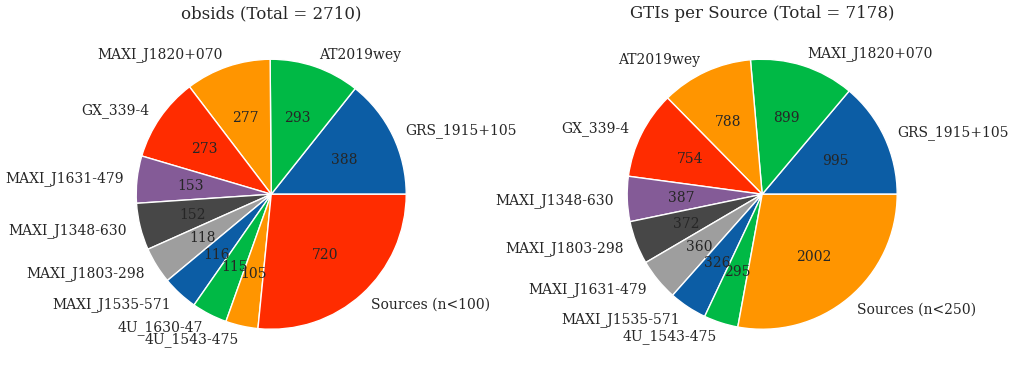

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))

source_set = np.unique(df['source'])
source_counts = np.array([len(np.where(source_list==source)[0]) for source in source_set])
count_cutoff = 100
other_sources_mask = source_counts < count_cutoff
other_sources_count = np.sum(source_counts[other_sources_mask])
filtered_source_set = source_set[~other_sources_mask]
filtered_source_counts = source_counts[~other_sources_mask]

idx = np.argsort(filtered_source_counts)[::-1]

def absolute_value(val):
    a  = int(np.round(val/100.*np.append(filtered_source_counts, other_sources_count).sum(), 0))
    return a

other_sources_mask = source_counts < count_cutoff
other_sources_count = np.sum(source_counts[other_sources_mask])
filtered_source_set = source_set[~other_sources_mask]
filtered_source_counts = source_counts[~other_sources_mask]
idx = np.argsort(filtered_source_counts)[::-1]

axs[0].pie(np.append(filtered_source_counts[idx], [other_sources_count]), labels=np.append(filtered_source_set[idx], [f'Sources (n<{count_cutoff})']),
           textprops={'size': 'smaller'}, autopct=absolute_value)
axs[0].set(title=f'obsids (Total = {np.sum(filtered_source_counts)+np.sum(other_sources_count)})')

source_set = np.unique(df['source'])
source_counts = np.array([np.sum(gti_counts[np.where(source_list==source)[0]]) for source in source_set])
count_cutoff = 250
other_sources_mask = source_counts < count_cutoff
other_sources_count = np.sum(source_counts[other_sources_mask])
filtered_source_set = source_set[~other_sources_mask]
filtered_source_counts = source_counts[~other_sources_mask]
idx = np.argsort(filtered_source_counts)[::-1]

axs[1].pie(np.append(filtered_source_counts[idx], [other_sources_count]), labels=np.append(filtered_source_set[idx], [f'Sources (n<{count_cutoff})']),
           textprops={'size': 'smaller'}, autopct=absolute_value)

axs[1].set(title=f'GTIs per Source (Total = {np.sum(filtered_source_counts)+np.sum(other_sources_count)})')

fig.tight_layout()

In [49]:
[len(df['source']==source) for source in source_set]

[2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710,
 2710]

In [81]:
df['source'].to_numpy()==source_set[0]
print(scienceplots.__file__)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/scienceplots/__init__.py
